In [1]:
%load_ext autoreload
%autoreload 2

## Imports

### Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import copy
from datetime import time
import wandb

### Custom

In [3]:
from cv_geoguessr.data.StreetViewImagesDataset import StreetViewImagesDataset

from cv_geoguessr.grid.grid_partitioning import Partitioning

from cv_geoguessr.utils.plot_images import plot_images

from cv_geoguessr.utils.evaluation import create_confusion_matrix


## Colab specific

Run only when using Colab.

In [3]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

## Logging in via WandB

In [4]:
wandb.init(project="CV-GeoGuessr", entity="cv-geoguessr")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: douwe (cv-geoguessr). Use `wandb login --relogin` to force relogin


## Model constants

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 100

CELL_WIDTH = 0.015
VORONOI = True

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225], device=device)

CITY_BOUNDS_FILE = '../data/metadata/citybounds/london.csv'
CITY_BOUNDS_FILE_GCLOUD = '../data/metadata/city bounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
DOUWE_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'
SJOERD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train_img" if train else "test_img"}/london/'
GCLOUD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train" if train else "test"}/'

LONDON_PHOTO_DIR = DOUWE_LONDON_PHOTO_DIR

SESSION = "douwe_local_test"
BASE_FOLDER = "./checkpoints"
CHECKPOINT_FOLDER = f'{BASE_FOLDER}/{SESSION}/'

wandb.config.update(
    {
        "train_batch_size": TRAIN_BATCH_SIZE,
        "test_batch_size": TEST_BATCH_SIZE,
        "cell_width": CELL_WIDTH,
        "session": SESSION,
        "voronoi": VORONOI,
    }
)


Device: cpu


## Model setup

### ImageNet

In [6]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

--2022-06-13 00:46:55--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10,23K  --.-KB/s    in 0,003s  

2022-06-13 00:46:55 (3,62 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [7]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

### Places365

In [8]:
# load the class label
file_name = 'categories_places365.txt'

if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)

categories = list()

with open(file_name) as class_file:
    for line in class_file:
        categories.append(line.strip().split(' ')[0][3:])
        
classes = tuple(categories)

## Download ResNet50

### Original

In [10]:
resnet50 = models.resnet50(pretrained=True, progress=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

wandb.config.update({"model": "resnet50"})

print('Downloaded ResNet50')

Downloaded ResNet50


### Places365

In [9]:
# th architecture to use
arch = 'resnet50'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)

resnet50 = model

resnet50.to(device)

wandb.config.update({"model": "places365"})

print('Downloaded Places365')

Downloaded Places365


### Summary

In [10]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Load the data

### Set up grid portioning

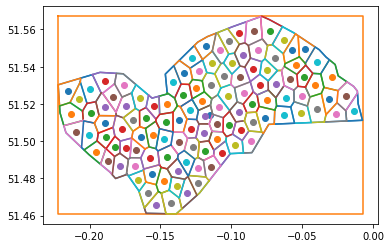

In [11]:
grid_partitioning = Partitioning(CITY_BOUNDS_FILE, CELL_WIDTH, VORONOI)

grid_partitioning.plot()

### Create the data loaders

In [12]:
brightness = 0.2
contrast = 0.2
saturation = 0.05
hue = 0.1

distortion_scale = .5
p = .4

wandb.config.update({"augmentation": {"color_jitter": {"brightness": brightness, "contrast": contrast, "saturation": saturation, "hue": hue }, "random_perspective": {"distortion_scale": distortion_scale, "p": p}}})

# Add additional random transformation to augment the training dataset
data_transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomPerspective(distortion_scale = distortion_scale, p = p),
    transforms.Resize(256),
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(brightness = brightness, contrast = contrast, saturation = saturation, hue = hue),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

data_transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(True), grid_partitioning, data_transforms_train)
train_loader = DataLoader(train_data_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(False), grid_partitioning, data_transforms_test)
test_loader = DataLoader(test_data_set, batch_size=TEST_BATCH_SIZE, shuffle=True)

data_loaders = {
    "train": train_loader,
    "val": test_loader
}


data_set_sizes = {
    'train':len(train_data_set),
    'val':len(test_data_set),
}

print(data_set_sizes)

{'train': 10038, 'val': 2000}


### Preview some training images

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


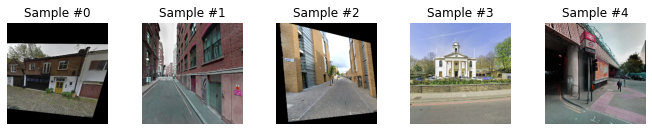

In [13]:
examples = enumerate(train_loader)
batch_idx, (eval_images, eval_coordinates) = next(examples)

plot_images(eval_images[:SAMPLES_TO_SHOW], IMAGENET_MEAN, IMAGENET_STD)

In [14]:
eval_coordinates[0, :]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Evaluate the model

In [15]:
resnet50.eval()

check_images = eval_images[:SAMPLES_TO_SHOW].to(device)

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(check_images), dim=1)

In [16]:
for i in output:
    top5_prob, top5_catid = torch.topk(i, 5)

    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    print()

car mirror 0.2757493257522583
television 0.15036045014858246
monitor 0.06945744901895523
traffic light 0.05372324958443642
window screen 0.03043542057275772

car mirror 0.2160467803478241
barn 0.13381199538707733
church 0.07068504393100739
viaduct 0.06507615000009537
television 0.056834470480680466

parking meter 0.12322434782981873
sports car 0.10892300307750702
limousine 0.09978926181793213
prison 0.05696333572268486
convertible 0.04979008063673973

prison 0.15491771697998047
car mirror 0.10976577550172806
bannister 0.04988306760787964
traffic light 0.03339341655373573
shopping cart 0.02711343951523304

window screen 0.2771530747413635
church 0.06890442967414856
umbrella 0.06725753843784332
sliding door 0.06578754633665085
monitor 0.022822724655270576



torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


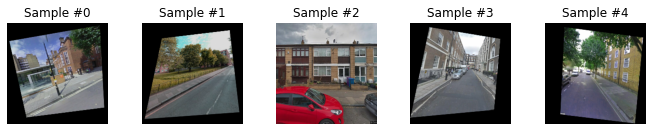

In [17]:
plot_images(check_images.to('cpu'), IMAGENET_MEAN, IMAGENET_STD)

## Train on the grid output


In [46]:
lr = 0.001
momentum = 0.9
gamma = 0.1
lr_decay_step = 7
num_epochs = 50

wandb.config.update({"lr": lr, "momentum": momentum, "gamma": gamma, "lr_decay_step": lr_decay_step, "epochs": num_epochs})

In [47]:
from torch.optim import lr_scheduler
from torch import optim

number_of_grid_elements = len(grid_partitioning.cells)

wandb.config.update({"number_of_grid_elements": number_of_grid_elements})

for param in resnet50.parameters():
    param.requires_grad = False

resnet50.fc = nn.Linear(resnet50.fc.in_features, number_of_grid_elements)
resnet50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# We might not want this for the initial few epochs I (sjoerd) think but lets just roll with it
optimizer_ft = optim.SGD(resnet50.fc.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=lr_decay_step, gamma=gamma)

In [48]:
summary(resnet50, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
import os

if not os.path.isdir(CHECKPOINT_FOLDER):
    os.makedirs(CHECKPOINT_FOLDER)

torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + "0.ckpt")

In [53]:
import copy
import time


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Trains a model, based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

    :param model: the model to train
    :param criterion: the criterion to use
    :param optimizer: the optimizer to use
    :param scheduler: torch.optim.lr_scheduler
    :param num_epochs:
    :return: a trained model
    """

    since = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        train_acc = 0
        test_acc = 0

        distance_error = {}
        distance_error_count = {}

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward: track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # Add distance error metric
                    _, actual_label_index = torch.max(labels, 1)
                    for index, label in enumerate(actual_label_index[preds != actual_label_index].tolist()):
                        distance_error.setdefault(label, 0)
                        distance_error[label] += (grid_partitioning.cells[label].centroid).distance(grid_partitioning.cells[preds[index]].centroid)

                        distance_error_count.setdefault(label, 0)
                        distance_error_count[label] += 1

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                _, actual_label_index = torch.max(labels, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == actual_label_index)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / data_set_sizes[phase]
            epoch_acc = running_corrects.double() / data_set_sizes[phase]
            
            # Append avg distance error
            avg_distance = 0
            for k in distance_error:
                avg_distance += distance_error[k] / distance_error_count[k]
            avg_distance /= len(distance_error.keys())

            # writer.add_scalar(f"Loss/{phase}", epoch_loss, epoch)
            wandb.log({f"Loss/{phase}": epoch_loss, "epoch": epoch})
            # writer.add_scalar(f"Accuracy/{phase}", epoch_acc, epoch)
            wandb.log({f"Accuracy/{phase}": epoch_acc, "epoch": epoch})

            wandb.log({f"Distance/{phase}": avg_distance, "epoch": epoch})

            if phase == 'train':
                train_acc = epoch_acc
            else:
                test_acc = epoch_acc

            print(f'{phase} loss: {epoch_loss:.4f} | accuracy: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

        print(f"{train_acc}\t{test_acc}")

        torch.save(resnet50.state_dict(),
                   CHECKPOINT_FOLDER + f"epoch_{epoch}.ckpt")

    time_elapsed = time.time() - since

    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model)

    return model

In [3]:
# Lets train the model
resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

NameError: name 'train_model' is not defined

## Train convolution layers

In [28]:
from collections import OrderedDict

def model_layers(model, input_size, batch_size=-1, device="cuda"):
    """Returns the layers of the model flattened, based on the summary code"""

    def register_hook(module):

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(layers)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            layers[m_key] = OrderedDict()
            layers[m_key]["input_shape"] = list(input[0].size())
            layers[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                layers[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                layers[m_key]["output_shape"] = list(output.size())
                layers[m_key]["output_shape"][0] = batch_size

            params = 0
            layers[m_key]["params"] = module.parameters()
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                layers[m_key]["trainable"] = module.weight.requires_grad
                layers[m_key]["weights"] = module.weight
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            layers[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()

    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    layers = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    return layers


# load an old model
def load_model(model, PATH, lock_factor, device):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint)

    layers = model_layers(model, (3, 224, 224))
    n = len(layers)
    print(n)  # 10 layers
    # print(model_layers)

    for i, layer in enumerate(layers):
        # for layer_param in layer.parameters():
        #     layer_param.requires_grad = i > n * lock_factor
        for param in layers[layer]["params"]:
            param.requires_grad = i > n * lock_factor

    model.to(device)
    summary(model, (3, 224, 224))

    return model


In [29]:
MODEL_TO_LOAD_PATH = BASE_FOLDER + "/second_test/epoch_24.ckpt"
lock_factor = 0.8

resnet50 = load_model(resnet50, MODEL_TO_LOAD_PATH, lock_factor, device)

174
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 

In [102]:
# now train with the loaded model with more layers unlocked

optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


E:\Boeken\Jaar 5\Q4 Computer Vision\CV-GeoGuessr\env\Lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.9487 Acc: 0.3465
val Loss: 1.9301 Acc: 0.3450
0.3464833632197649	0.34500000000000003
Epoch 1/24
----------
train Loss: 1.5274 Acc: 0.5008
val Loss: 1.9126 Acc: 0.3580
0.5007969715082686	0.358
Epoch 2/24
----------
train Loss: 1.0542 Acc: 0.6815
val Loss: 2.0734 Acc: 0.3465
0.6815102610081689	0.34650000000000003
Epoch 3/24
----------
train Loss: 0.5307 Acc: 0.8741
val Loss: 2.2524 Acc: 0.3405
0.8740785016935645	0.3405
Epoch 4/24
----------
train Loss: 0.2094 Acc: 0.9667
val Loss: 2.4214 Acc: 0.3430
0.9667264395297868	0.343
Epoch 5/24
----------
train Loss: 0.0924 Acc: 0.9892
val Loss: 2.5539 Acc: 0.3475
0.9892408846383742	0.34750000000000003
Epoch 6/24
----------
train Loss: 0.0539 Acc: 0.9949
val Loss: 2.6307 Acc: 0.3480
0.9949193066347878	0.34800000000000003
Epoch 7/24
----------
train Loss: 0.0339 Acc: 0.9977
val Loss: 2.7051 Acc: 0.3540
0.9977087069137278	0.354
Epoch 8/24
----------
train Loss: 0.0256 Acc: 0.9983
val Loss: 2.7668 Acc: 0.3470
0.9983064355449293	0.347000

In [72]:
# Running the model evaluation
# def run_evaluation(model, partitions, predictions=True):
#     n = len(partitions.cells)
#     confusion_matrix = torch.zeros((n, n)).to(device)
#
#     i = 0
#     for inputs, labels in dataloaders['val']:
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#
#         # forward
#         with torch.set_grad_enabled(False):
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#
#         for label, output, pred in zip(labels, outputs, preds):
#             l = torch.argmax(label)
#             # print(l)
#
#             if predictions:
#                 confusion_matrix[l, :] += pred
#             else:
#                 confusion_matrix[l, :] += output
#
#             i += 1
#
#     return confusion_matrix


In [79]:
confusion_matrix = create_confusion_matrix(resnet50, grid_partitioning, dataloaders['val'], False, device)
print(confusion_matrix.to('cpu'))

tensor([[-4.5497e+00,  3.0342e+00,  1.6583e+00, -1.6565e+00,  2.4460e+00,
          4.3701e+00,  4.3774e+00,  2.6206e+00,  1.5412e+00,  2.1699e-01,
         -7.1319e+00, -3.2594e+00, -3.9742e-01,  9.9407e-01,  4.2978e-01,
         -4.9362e+00],
        [-3.0604e+02,  1.6758e+02,  1.6168e+02, -1.0409e+02,  9.1378e+01,
          2.2592e+02,  1.4526e+02,  9.2371e+01,  6.9114e+01,  4.4319e+00,
         -3.9812e+02, -2.0476e+02, -5.2192e-01,  1.0734e+02,  7.0945e+01,
         -2.1663e+02],
        [-4.5690e+02,  9.6806e+01,  2.5175e+02, -1.3530e+02,  9.4579e+01,
          2.0735e+02,  1.3811e+02,  1.6020e+02,  1.5053e+02,  7.8627e+01,
         -5.4200e+02, -2.7470e+02,  3.5680e+01,  1.6638e+02,  1.3100e+02,
         -2.6751e+02],
        [-4.7063e+01,  6.6898e+00,  1.8858e+01, -1.2877e+01,  8.4763e+00,
          1.9689e+01,  1.2630e+01,  1.6775e+01,  1.7211e+01,  1.1477e+01,
         -5.4434e+01, -2.7457e+01,  6.3426e+00,  1.7894e+01,  1.6783e+01,
         -2.6154e+01],
        [-3.7213e+02

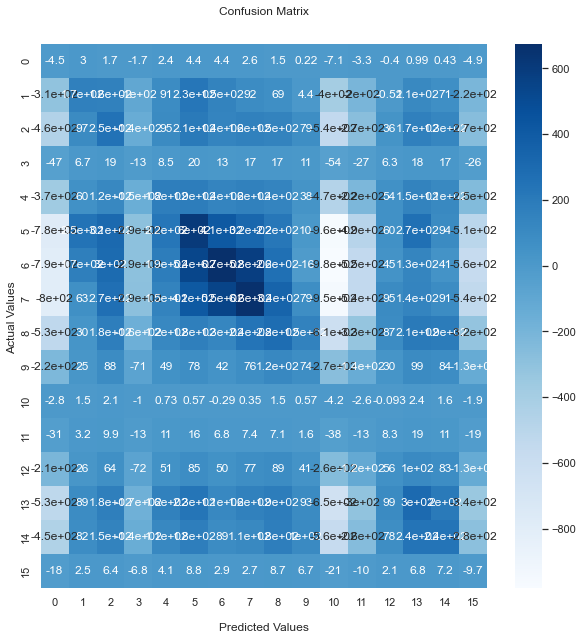

In [81]:
from cv_geoguessr.utils.plot_results import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix)